# Emotion Detection con tecniche di Deep Learning

## Import delle librerie

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, SimpleRNN, LSTM
from keras.utils import get_file, plot_model
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import os
import glob
import math
import wave #used to calculate audio file length
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output, Audio #used for cleaning too long cells output, used to play tracks
import librosa
import librosa.display

## Utility functions

In [ ]:
def plot_history(history,metric=None):
  fig, ax1 = plt.subplots(figsize=(10, 8))

  epoch_count=len(history.history['loss'])

  line1,=ax1.plot(range(1,epoch_count+1),history.history['loss'],label='train_loss',color='orange')
  ax1.plot(range(1,epoch_count+1),history.history['val_loss'],label='val_loss',color = line1.get_color(), linestyle = '--')
  ax1.set_xlim([1,epoch_count])
  ax1.set_ylim([0, max(max(history.history['loss']),max(history.history['val_loss']))])
  ax1.set_ylabel('loss',color = line1.get_color())
  ax1.tick_params(axis='y', labelcolor=line1.get_color())
  ax1.set_xlabel('Epochs')
  _=ax1.legend(loc='lower left')

  if (metric!=None):
    ax2 = ax1.twinx()
    line2,=ax2.plot(range(1,epoch_count+1),history.history[metric],label='train_'+metric)
    ax2.plot(range(1,epoch_count+1),history.history['val_'+metric],label='val_'+metric,color = line2.get_color(), linestyle = '--')
    ax2.set_ylim([0, max(max(history.history[metric]),max(history.history['val_'+metric]))])
    ax2.set_ylabel(metric,color=line2.get_color())
    ax2.tick_params(axis='y', labelcolor=line2.get_color())
    _=ax2.legend(loc='upper right')

## Dataset

Il dataset è una sottoporzione del dataset RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song). Mentre il RAVDESS puro contiene 24.8GB di discorsi e di canzoni, audio e video, il RAVDESS Emotional speech audio contiene solo audio di discorsi.

Il dataset contiene 60 tracce audio per ognuno dei 24 attori, per un totale di 1440 file in formato war. Gli attori (12 maschi e 12 femmine) pronunciano 2 frasi (2 volte ciascuna) con un accento neutro del Norm America esprimendo emozioni differenti (calma, felicità, tristezza, rabbia, paura, sorpresa e disgusto) a 2 differenti livelli di intensità (medio, alto) più un'espressione neutra.

La **naming convention** dei file del dataset è la seguente: ognuno dei 1440 file è identificato da una successione di 7 identificatori numerici (es. 03-01-06-01-02-01-12.wav) e ognuno di questi numeri ha un significato specifico:

* **Modalità** (01: audio-video, 02: solo video, 03: solo audio)
  * in questa sottoporzione del dataset la modalità è sempre audio-only
* **Canale vocale** (01: parlato, 02: cantato)
  * in questa sottoporzione del dataset il canale vocale è sempre parlato 
* **Emozione** (01: neutra, 02: calma, 03: felicità, 04: tristezza, 05: rabbia, 06: paura, 07: disgusto, 08: sorpresa)
* **Intensità** (01: normale, 02: forte)
  * per l'emozione neutra non c'è intensità
* **Frase** (01: "Kids are talking by the door", 02: "Dogs are sitting by the door")
* **Ripetizione** (01: prima ripetizione, 02: seconda ripetizione)
* **Attore** (01...24, gli attori dispari sono maschi, mentre quelli pari sono femmine)

### Download

Viene scaricato il dataset in format RAR da Google Drive e successivamente viene estratto il contenuto dell'archivio. L'archivio sarà poi eliminato.

In [ ]:
zipped_dataset_path= "/content/audio_speech_actors.rar"
dataset_url = "https://drive.google.com/u/0/uc?id=15IrtKentayJQvgMQF6gJCBIP4xWiazzX&export=download&confirm=t&uuid=a911e909-c2fa-4fd4-8231-995cd8aba324"
get_file(zipped_dataset_path, dataset_url)

#extract dataset from zip file
!unrar x -Y $zipped_dataset_path
#delete zip file after extraction
os.remove(zipped_dataset_path)
#clean the output after extraction
clear_output(wait=False)

### Funzione di campionamento

Viene definita una utility function `sample_track` che restituisce in output il path di una traccia casuale campionato dal dataset.

In [ ]:
dataset_path = "/content/Audio_Speech_Actors_01-24"
emotions = 8

def sample_track():
  #choose a random folder
  folders = sorted(glob.glob(dataset_path+"/*"), key=len)
  random_folder = np.random.choice(folders)
  #choose and return a random track
  tracks = sorted(glob.glob(random_folder+"/*.wav"), key=len)
  random_track = np.random.choice(tracks)
  return random_track  

In [ ]:
#sampling function testing 
random_track = sample_track()
#track visualization
Audio(random_track)

### Caricamento dei file audio

La funzione [load](https://librosa.org/doc/main/generated/librosa.load.html) di librosa permette di caricare un file audio come una sequenza temporale di valori floating point.

* `path` indica alla funzione il path del file caricare

La funzione restituisce la sequenza di valori floating point e la frequenza di campionatura (espressa in Hz). Il valore di default per la frequenza di campionatura è di 22.050 Hz, il che significa che una traccia audio di 3 secondi viene caricata come un vettore di 66.150 valori floatin point.

In [ ]:
#load the audio track as a floating point time series
time_series, sampling_rate = librosa.load(path=random_track)
print("sampling_rate: {}".format(sampling_rate))
print("time_series length: {}".format(len(time_series)))

sampling_rate: 22050
time_series length: 90496


la funzione `get_audio_length` restituisce la durata in secondi della traccia audio passata in input. Usa il package [wave](https://docs.python.org/3/library/wave.html) per estrarre l'informazione dai file WAV.

* `path` è il percorso della traccia audio

La funzione viene usata per verificare la lunghezza della serie temporale estratta da librosa, basterà infatti moltiplicare la lunghezza del file per il rateo di campionatura e controllare se il valore coincide con il numero di valori estratti da librosa. 


In [ ]:
def get_audio_length(path):
    file = wave.open(path, 'r')
    frames = file.getnframes()
    #print("frames: ", frames)
    rate = file.getframerate()
    #print("frame rate: ", rate)
    return frames / float(rate)

In [ ]:
audio_length = get_audio_length(random_track)
print("audio length: {}".format(audio_length))
print("expected time series length: {}".format(math.ceil(audio_length * sampling_rate)))

audio length: 4.104104166666667
expected time series length: 90496


/usr/local/lib/python3.9/dist-packages/librosa/util/utils.py:198: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  warnings.warn(


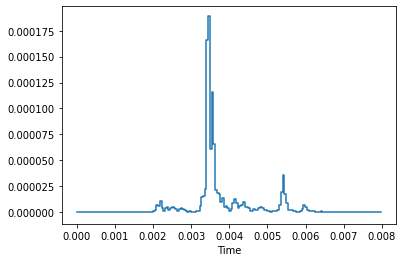

In [ ]:
#display track spectrogram
spectrogram = librosa.feature.melspectrogram(y=time_series, sr=sampling_rate)
librosa.display.waveshow(y=spectrogram, sr=sampling_rate)

### Visualizzazione

Per fini di visualizzazione viene costruito un DataFrame Pandas ottenuto dalle informazioni codificate nei nomi dei singoli file. In particolare le colonne saranno le seguenti: `Path`, `Emotion`, `Intensity`, `Statement`, `Actor`, `Gender`.

Prima vengono generati array di valori in base ai codici contenuti nei nomi dei file, poi quegli array vengono convertiti in dataframe con una singola colonna e infine i dataframes vengono concatenati per comporre il dataframe obiettivo.

In [ ]:
directories = os.listdir(dataset_path)

#support arrays to store database values
emotion_col = []
intensity_col = []
statement_col = []
actor_col = []
gender_col = []
path_col = []

#iterate over dataset folders (every folder is relative to a different actor)
for dir_name in directories:
  dir_files = os.listdir(dataset_path + "/" + dir_name)
  #iterate over files in the current directory
  for file_name in dir_files:
    #file name splitting: first remove WAV extension then split over '-' chars
    file_parts = file_name.split('.')[0].split('-')
    #store each value into the relative array
    emotion_col.append(int(file_parts[2]))
    intensity_col.append(int(file_parts[3]))
    statement_col.append(int(file_parts[4]))
    actor_col.append(int(file_parts[6]))
    gender_col.append(int(file_parts[6])%2) # %2 to keep only odd/even information
    path_col.append(dataset_path + "/" + dir_name + "/" + file_name)

#convert arrays to dataframes and chain them in a single dataframe
emotion_df = pd.DataFrame(emotion_col, columns=['Emotions'])
intensity_df = pd.DataFrame(intensity_col, columns=['Intensity'])
statement_df = pd.DataFrame(statement_col, columns=['Statement'])
actor_df = pd.DataFrame(actor_col, columns=['Actor'])
gender_df = pd.DataFrame(gender_col, columns=['Gender'])
path_df = pd.DataFrame(path_col, columns=['Path'])

#convert integer in dataframe with their value following the naming convention
#  inplace param added to edit the current dataframe instead of creating a new one
emotion_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fearful', 7:'disgust', 8:'surprised'}, inplace=True)
intensity_df.replace({1:'normal', 2:'strong'}, inplace=True)
statement_df.replace({1:'Kids are talking by the door', 2:'Dogs are sitting by the door'}, inplace=True)
gender_df.replace({1:'male', 0:'female'}, inplace=True)

files_df = pd.concat([path_df, emotion_df, intensity_df, statement_df, actor_df, gender_df], axis=1) #axis=1 to concatenate columns instead of rows
files_df

,Path,Emotions,Intensity,Statement,Actor,Gender
0,/content/Audio_Speech_Actors_01-24/Actor_12/03...,happy,normal,Kids are talking by the door,12,female
1,/content/Audio_Speech_Actors_01-24/Actor_12/03...,happy,strong,Dogs are sitting by the door,12,female
2,/content/Audio_Speech_Actors_01-24/Actor_12/03...,angry,strong,Kids are talking by the door,12,female
3,/content/Audio_Speech_Actors_01-24/Actor_12/03...,disgust,strong,Kids are talking by the door,12,female
4,/content/Audio_Speech_Actors_01-24/Actor_12/03...,surprised,strong,Kids are talking by the door,12,female
...,...,...,...,...,...,...
1435,/content/Audio_Speech_Actors_01-24/Actor_19/03...,angry,strong,Kids are talking by the door,19,male
1436,/content/Audio_Speech_Actors_01-24/Actor_19/03...,neutral,normal,Dogs are sitting by the door,19,male
1437,/content/Audio_Speech_Actors_01-24/Actor_19/03...,angry,normal,Dogs are sitting by the door,19,male
1438,/content/Audio_Speech_Actors_01-24/Actor_19/03...,calm,strong,Kids are talking by the door,19,male


### Features

#### Short-Time Fourier Transform

<!--
La **Fourier Transform** (FT) è una funzione matematica in grado di decomporre un segnale nelle sue frequenze costituenti corredate dalle relative magnitudo. La FT permette di passare dal dominio del tempo (time-domain) a quello della frequenza (frequency-domain).

<div>
<img src="https://drive.google.com/uc?id=12vRYA33koEKGD2fvZOYKUxMBhkXzd3ab"/>
</div>

La libreria librosa contiene una funzione per il calcolo della **Discrete Fourier Transform** (DFT), chiamata anche **Fast Fourier Transform** (FFT), funzione matematica che si differenzia dalla FT per il fatto di prendere un input discreto, piuttosto che un input continuo come nella FT standard.

La frequenza cambia nel tempo, quindi una FT su tutta la traccia audio può non essere rappresentativa. La **Short-Time Fourier Transform** (STFT) effettua una FT su sottoporzioni della traccia stessa.

La STFT viene calcolata usando la funzione [stft](https://librosa.org/doc/main/generated/librosa.stft.html) di librosa, che di norma restituisce un vettore di numeri complessi (float64), che codificano fase e ampiezza del segnale audio, ma la fase, oltre a non venire percepita dall'essere umano, non è utile ai fini dell'esperimento, quindi convertono i valori della sequenza temporale in valori assoluti (float32).

**TODO** parlare del binning
-->

#### Estrazione

Dal dataset vengono estratte le features usando le funzioni offerte dalla libreria librosa:

* [chroma](https://librosa.org/doc/main/generated/librosa.feature.chroma_stft.html): **TODO** (12 valori per ogni file)
* [mel spctrogram](https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html): spettrogramma dove le frequenze sono state convertine nella scala MEL (128 valori per ogni file)
* [mfcc](https://librosa.org/doc/main/generated/librosa.feature.mfcc.html): **TODO** (40 valori per ogni file)
* [spectral contrast](https://librosa.org/doc/main/generated/librosa.feature.spectral_contrast.html): **TODO** (7 valori per ogni file)
* [tonnetz](https://librosa.org/doc/main/generated/librosa.feature.tonnetz.html): **TODO** (6 valori per ogni file)

I valori indicati tra parentesi (12,128,40,7,6 = **193 features**) indicano il numero di colonne di ogni feature, che verranno aggiunte al dataframe Pandas, corredato con l'informazione di classe (corrispondente all'emozione espressa nella traccia audio) del file corrispondente.

La funzione `get_features` estrae le 193 features dal file passato in input e restituisce 5 array, uno per ogni categoria di feature sopraelencata.

* `file_path` è il percorso del file per il quale estrarre le features

In [ ]:
def get_features(file_path):
  time_series, sample_rate = librosa.load(path=file_path)
  stft = np.abs(librosa.stft(time_series))

  chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
  mel_spectrogram = np.mean(librosa.feature.melspectrogram(time_series, sr=sample_rate).T,axis=0)
  mfcc = np.mean(librosa.feature.mfcc(y=time_series, sr=sample_rate, n_mfcc=40).T,axis=0)
  spectral_contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
  tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(time_series), sr=sample_rate).T,axis=0)
  return chroma, mel_spectrogram, mfcc, spectral_contrast, tonnetz

La funzione `get_feature_dataframe` restituisce un dataframe Pandas contenente le feature estratte da ogni file del dataset. Il dataframe conterrà quindi una riga per ogni file nel dataset (**1440 righe**) e una colonna per ogni feature più una colonna per ogni classe possibile (**193 + 8 = 201 colonne**).

Per la classe di appartenenza è stata utilizzata una rappresentazione in One Hot Encode (usando la funzione [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) di Pandas) per evitare che il modello apprenda relazioni in realtà non esistenti tra i valori della classe dei dati.

In [ ]:
def get_feature_dataframe():
  #support arrays to store feature values
  chroma_col = []
  mel_spectrogram_col = []
  mfcc_col = []
  spectral_contrast_col = []
  tonnetz_col = []

  for file_path in files_df['Path']:
    chroma, mel_spectrogram, mfcc, spectral_contrast, tonnetz = get_features(file_path)
    
    chroma_col.append(chroma)
    mel_spectrogram_col.append(mel_spectrogram)  
    mfcc_col.append(mfcc)
    spectral_contrast_col.append(spectral_contrast)
    tonnetz_col.append(tonnetz)

  #convert feature arrays to pandas dataframes and chain them them to obtain the feature dataframe
  chroma_df = pd.DataFrame(chroma_col)
  chroma_df.rename(columns=lambda i: 'Chroma_' + str(i+1), inplace=True)

  mel_df = pd.DataFrame(mel_spectrogram_col)
  mel_df.rename(columns=lambda i: 'MelSpectrogram_' + str(i+1), inplace=True)

  mfcc_df = pd.DataFrame(mfcc_col)
  mfcc_df.rename(columns=lambda i: 'MFCC_' + str(i+1), inplace=True)

  contrast_df = pd.DataFrame(spectral_contrast_col)
  contrast_df.rename(columns=lambda i: 'SpectralContrast_' + str(i+1), inplace=True)

  tonnetz_df = pd.DataFrame(tonnetz_col)
  tonnetz_df.rename(columns=lambda i: 'Tonnetz_' + str(i+1), inplace=True)

  emotion_df_ohe = pd.get_dummies(data=emotion_df, prefix="emotion", columns=["Emotions"])

  return pd.concat([chroma_df, mel_df, mfcc_df, contrast_df, tonnetz_df, emotion_df_ohe], axis=1)

### Creazione del dataframe

Il seguente blocco di codice permette di decidere se ricreare il dataframe o se caricare la versione salvata su Drive, risparmiando il tempo necessario per la costruzione.

In [ ]:
#True -> load dataframe from csv, False -> regenerate dataframe 
load_dataframe = True

if load_dataframe:
  #get file from drive
  dataframe_path= "/content/dataframe.csv"
  dataframe_url = "https://drive.google.com/u/0/uc?id=18ah3jxrpOsOdJDueiVZ1HJGMIWvng3VM&export=download&confirm=t&uuid=a911e909-c2fa-4fd4-8231-995cd8aba324"
  get_file(dataframe_path, dataframe_url)
  #create dataframe from CSV file
  dataframe = pd.read_csv(dataframe_path)
else:
  #create dataframe from dataset
  print("creating dataframe...")
  dataframe = get_feature_dataframe()
  print("dataframe creation completed!")
  #save dataframe ad CSV file
  dataframe.to_csv("dataframe.csv", index=False) #index param avoid to save row names (unused information)

3498128/3498128 [==============================] - 0s 0us/step


Viene usata la funzione [info](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html) dei DataFrame Pandas per visualizzare informazioni interessanti sul DataFrame. A causa del elevato numero di colonne è necessario impostare il parametro `verbose` per forzare la visualizzazione completa.

In [ ]:
dataframe.info()
#dataframe.info(verbose=True) #used only for debug purpose

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Columns: 201 entries, Chroma_1 to emotion_8
dtypes: float64(193), int64(8)
memory usage: 2.2 MB


In [ ]:
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Chroma_1,1440.0,0.653012,0.076961,0.368978,0.603202,0.660133,0.709243,0.840076
Chroma_2,1440.0,0.655451,0.086802,0.323143,0.596900,0.661806,0.723560,0.866417
Chroma_3,1440.0,0.657881,0.090173,0.316588,0.594463,0.666341,0.726483,0.865543
Chroma_4,1440.0,0.645479,0.091483,0.328986,0.580172,0.660191,0.713162,0.859511
Chroma_5,1440.0,0.617110,0.089320,0.344638,0.552021,0.636111,0.684158,0.819569
...,...,...,...,...,...,...,...,...
emotion_4,1440.0,0.133333,0.340053,0.000000,0.000000,0.000000,0.000000,1.000000
emotion_5,1440.0,0.133333,0.340053,0.000000,0.000000,0.000000,0.000000,1.000000
emotion_6,1440.0,0.133333,0.340053,0.000000,0.000000,0.000000,0.000000,1.000000
emotion_7,1440.0,0.133333,0.340053,0.000000,0.000000,0.000000,0.000000,1.000000


### Splitting

In [ ]:
x = dataframe.iloc[:,:193]
x = x.to_numpy()
x = x.reshape((x.shape[0], x.shape[1], 1))
y = dataframe.iloc[:,193:]

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=240)

print("""Shape list:\ntraining set: {}\ntraining set categories: {}\ntest set: {}\ntest set categories: {}"""
.format(train_x.shape, train_y.shape, test_x.shape, test_y.shape))

Shape list:
training set: (1200, 193, 1)
training set categories: (1200, 8)
test set: (240, 193, 1)
test set categories: (240, 8)


In [ ]:
features_count = x.shape[1]
classes_count = y.shape[1]

print("Number of features: {}".format(features_count)) 
print("Number of classes(emotions): {}".format(classes_count))

Number of features: 193
Number of classes(emotions): 8



## RNN base

Il primo esperiemnto viene condotto usando una RNN many-to-one standard, cioè con un unico nodo. 



![alt text](https://biolab.csr.unibo.it/ferrara/Courses/DL/Tutorials/RNN/ManyToOne_RNN.png)

### Definizione del modello

[SimpleRNN](https://keras.io/api/layers/recurrent_layers/simple_rnn/)

In [ ]:
def build_simple_rnn(n_feature,n_classes):
  model = keras.Sequential(
      [
        Input(shape=(n_feature,1)),
        SimpleRNN(n_classes, activation="softmax")
      ]
    )

  return model

### Creazione del modello

In [ ]:
simple_rnn = build_simple_rnn(features_count, classes_count)

### Visualizzazione del modello

In [ ]:
simple_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


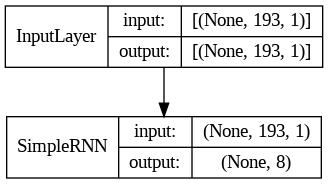

In [ ]:
plot_model(simple_rnn, show_shapes=True, show_layer_names=False)

### Compilazione del modello

In [ ]:
simple_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training del modello

In [ ]:
epoch_count = 100

history = simple_rnn.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=epoch_count, batch_size=32)

Epoch 1/100
38/38 [==============================] - 3s 43ms/step - loss: 2.0872 - accuracy: 0.1308 - val_loss: 2.0894 - val_accuracy: 0.1458
Epoch 2/100
38/38 [==============================] - 1s 35ms/step - loss: 2.0819 - accuracy: 0.1308 - val_loss: 2.0834 - val_accuracy: 0.1458
Epoch 3/100
38/38 [==============================] - 3s 69ms/step - loss: 2.0777 - accuracy: 0.1308 - val_loss: 2.0790 - val_accuracy: 0.1458
Epoch 4/100
38/38 [==============================] - 2s 43ms/step - loss: 2.0746 - accuracy: 0.1308 - val_loss: 2.0756 - val_accuracy: 0.1458
Epoch 5/100
38/38 [==============================] - 1s 34ms/step - loss: 2.0721 - accuracy: 0.1317 - val_loss: 2.0725 - val_accuracy: 0.1458
Epoch 6/100
38/38 [==============================] - 1s 36ms/step - loss: 2.0703 - accuracy: 0.1350 - val_loss: 2.0694 - val_accuracy: 0.1417
Epoch 7/100
38/38 [==============================] - 1s 35ms/step - loss: 2.0686 - accuracy: 0.1167 - val_loss: 2.0674 - val_accuracy: 0.0958
Epoch 

KeyboardInterrupt: ignored

In [ ]:
plot_history(history,'accuracy')

In [ ]:
def predict_from_sample(model):
  #sample random data from dataset
  random_index = #TODO
  data = x[1,:,:]
  #reshape data to conform to model input shape
  data = data.reshape((1,data.shape[0], data.shape[1]))
  #make prediction
  res = simple_rnn.predict(data)
  #pick predicted emotion index
  emotion_index = np.argmax(res)
  #convert emotion index to emotion label
  emotion_label = #TODO
  #return emotion label
  return emotion_label

## LSTM

In [ ]:
def build_lstm(n_feature,n_classes):
  model = keras.Sequential(
      [
        Input(shape=(n_feature,1)),
        LSTM(n_classes, activation="softmax")
      ]
    )

  return model

### Creazione del modello

In [ ]:
lstm = build_lstm(features_count, classes_count)

### Visualizzazione del modello

In [ ]:
lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 8)                 320       
                                                                 
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________


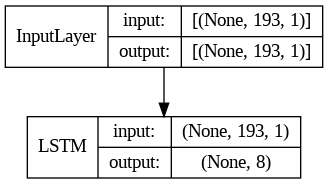

In [ ]:
plot_model(lstm, show_shapes=True, show_layer_names=False)

### Compilazione del modello

In [ ]:
optimizer = Adam(learning_rate=0.003)

lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training del modello

In [ ]:
epoch_count = 100

history = lstm.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=epoch_count, batch_size=32)

Epoch 1/100
38/38 [==============================] - 5s 81ms/step - loss: 2.0800 - accuracy: 0.1242 - val_loss: 2.0786 - val_accuracy: 0.1208
Epoch 2/100
38/38 [==============================] - 3s 71ms/step - loss: 2.0772 - accuracy: 0.1300 - val_loss: 2.0755 - val_accuracy: 0.1250
Epoch 3/100
38/38 [==============================] - 3s 72ms/step - loss: 2.0749 - accuracy: 0.1300 - val_loss: 2.0729 - val_accuracy: 0.1208
Epoch 4/100
38/38 [==============================] - 4s 108ms/step - loss: 2.0731 - accuracy: 0.1267 - val_loss: 2.0710 - val_accuracy: 0.1167
Epoch 5/100
38/38 [==============================] - 3s 70ms/step - loss: 2.0716 - accuracy: 0.1217 - val_loss: 2.0694 - val_accuracy: 0.0833
Epoch 6/100
38/38 [==============================] - 3s 71ms/step - loss: 2.0702 - accuracy: 0.1367 - val_loss: 2.0679 - val_accuracy: 0.1125
Epoch 7/100
38/38 [==============================] - 3s 70ms/step - loss: 2.0692 - accuracy: 0.1467 - val_loss: 2.0672 - val_accuracy: 0.0958
Epoch

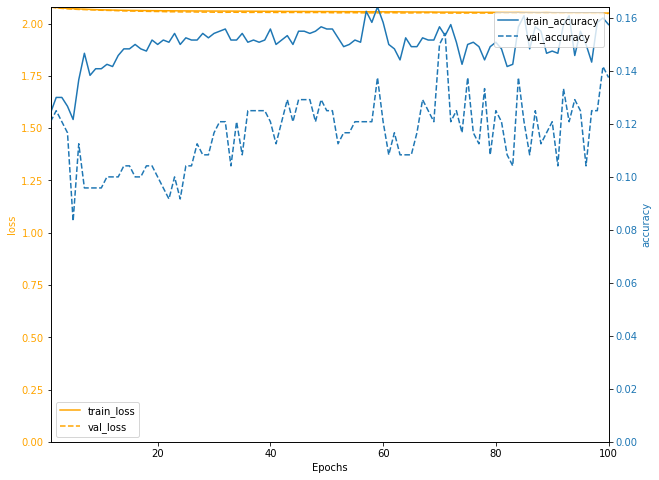

In [ ]:
plot_history(history,'accuracy')